In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Importing Data & Exploring Structure

In [ ]:
detroit_weather = pd.read_csv('daily_detroit_weather.csv')

detroit_weather.head()

,date,temperature_2m_max (F),precipitation_sum (inch),snowfall_sum (inch),relative_humidity_2m_mean (%),dew_point_2m_mean (F),surface_pressure_mean (hPa),wind_speed_10m_mean (mp/h),cloud_cover_mean (%)
0,1/1/2000,46.3,0.000,0.0,74,26.6,995.3,8.8,52
1,1/2/2000,53.9,0.075,0.0,93,44.4,987.3,14.3,85
2,1/3/2000,47.3,0.406,0.0,94,35.0,990.3,11.6,93
3,1/4/2000,48.8,0.134,0.0,74,29.0,983.4,16.5,95
4,1/5/2000,29.9,0.000,0.0,57,13.8,1003.6,7.7,92


In [ ]:
detroit_weather.shape

(9446, 9)

#### Datatypes, Missing Values, and Column Names

In [ ]:
detroit_weather.dtypes

,0
date,object
temperature_2m_max (F),float64
precipitation_sum (inch),float64
snowfall_sum (inch),float64
relative_humidity_2m_mean (%),int64
dew_point_2m_mean (F),float64
surface_pressure_mean (hPa),float64
wind_speed_10m_mean (mp/h),float64
cloud_cover_mean (%),int64


All variables are of acceptable data types, with the exception of `temperature_2m ((°F)` which will be converted to a pandas `datetime64` object

In [ ]:
detroit_weather['date'] = pd.to_datetime(detroit_weather['date'])

In [ ]:
detroit_weather.describe()

,date,temperature_2m_max (F),precipitation_sum (inch),snowfall_sum (inch),relative_humidity_2m_mean (%),dew_point_2m_mean (F),surface_pressure_mean (hPa),wind_speed_10m_mean (mp/h),cloud_cover_mean (%)
count,9446,9446.000000,9446.000000,9446.000000,9446.000000,9446.000000,9446.000000,9446.000000,9446.000000
mean,2012-12-05 12:00:00,57.667531,0.096158,0.075790,71.416790,40.844760,994.842357,9.495469,61.287423
min,2000-01-01 00:00:00,-4.500000,0.000000,0.000000,34.000000,-16.800000,966.300000,1.900000,0.000000
25%,2006-06-19 06:00:00,40.900000,0.000000,0.000000,64.000000,27.000000,990.700000,6.800000,39.000000
50%,2012-12-05 12:00:00,58.900000,0.004000,0.000000,72.000000,41.800000,994.900000,9.000000,66.000000
75%,2019-05-24 18:00:00,75.500000,0.087000,0.000000,79.000000,56.900000,999.000000,11.800000,87.000000
max,2025-11-10 00:00:00,100.100000,2.232000,7.661000,99.000000,75.600000,1019.700000,26.400000,100.000000
std,NaN,19.865220,0.207118,0.379708,10.825426,18.691149,6.685341,3.626255,29.219403


### Splitting Data into Train & Test

In [ ]:
val_split_idx = int(0.8 * len(detroit_weather))
test_split_idx = int(0.9 * len(detroit_weather))

val_split_date = detroit_weather.iloc[val_split_idx, 0]
test_split_date = detroit_weather.iloc[test_split_idx, 0]

In [ ]:
train_df = detroit_weather.iloc[:val_split_idx]
val_df = detroit_weather.iloc[val_split_idx:test_split_idx]
test_df = detroit_weather.iloc[test_split_idx:]

print(f'Training Date Range: ({train_df['date'].min()}) → ({train_df['date'].max()})')
print(f'Validation Date Range: ({val_df['date'].min()}) → ({val_df['date'].max()})')
print(f'Testing Date Range: ({test_df['date'].min()}) → ({test_df['date'].max()})')

Training Date Range: (2000-01-01 00:00:00) → (2020-09-07 00:00:00)
Validation Date Range: (2020-09-08 00:00:00) → (2023-04-10 00:00:00)
Testing Date Range: (2023-04-11 00:00:00) → (2025-11-10 00:00:00)


### Baseline Model

#### Naive

In [ ]:
actual = detroit_weather['temperature_2m_max (F)'].to_numpy()

testing_actual = actual[test_split_idx:]
naive_predictions = np.roll(actual, 1)[test_split_idx:]

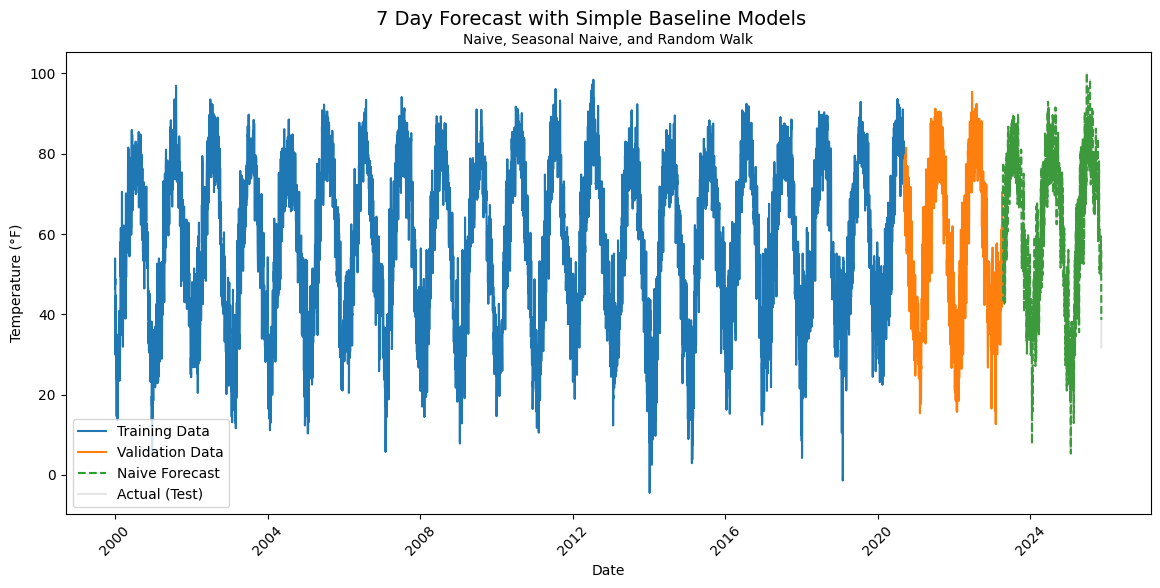

In [ ]:
plt.figure(figsize=(14, 6))

# training data for last 100 days
plt.plot(train_df['date'], train_df['temperature_2m_max (F)'], label='Training Data')
plt.plot(val_df['date'], val_df['temperature_2m_max (F)'], label = 'Validation Data')

# Naive forecast values
plt.plot(test_df['date'], naive_predictions, label='Naive Forecast', linestyle = '--')
plt.plot(test_df['date'], test_df['temperature_2m_max (F)'], label='Actual (Test)', alpha=0.2, color = 'grey')

plt.suptitle('7 Day Forecast with Simple Baseline Models', y = 0.95, fontsize = 14)
plt.title('Naive, Seasonal Naive, and Random Walk', fontsize = 10)
plt.xlabel('Date'); plt.ylabel('Temperature (°F)')

plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [ ]:
naive_mse = np.sqrt(np.mean(np.square(testing_actual - naive_predictions)))

print(f'MSE for Naive model: {naive_mse}')

MSE for Naive model: 7.128903831674954


### Univariate LSTM - Predicting Temperature Using Previous `t` Days

In [ ]:
# hyperparameters
lookback = 7
batch_size = 64
hidden_size = 32
num_layers = 1
learning_rate = 0.0001
num_epochs = 100

In [ ]:
temp_only = detroit_weather[['date', 'temperature_2m_max (F)']] # subset to include only datetime and temperature

temp_only.head(13)

,date,temperature_2m_max (F)
0,2000-01-01,46.3
1,2000-01-02,53.9
2,2000-01-03,47.3
3,2000-01-04,48.8
4,2000-01-05,29.9
5,2000-01-06,37.4
6,2000-01-07,30.9
7,2000-01-08,42.0
8,2000-01-09,38.2
9,2000-01-10,44.7


#### Array Manipulation & Reshaping

##### Shift data to include observed temperature, and observed temperature of 72 previous hours

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('date', inplace=True)

    # for each date, there are 't - n_steps' previous days data
    for i in range(1, n_steps+1):
        df[f'Temperature (t-{i})'] = df['temperature_2m_max (F)'].shift(i)

    df.dropna(inplace=True)

    return df

In [ ]:
shifted_df = prepare_dataframe_for_lstm(temp_only, lookback)
shifted_df.head()

,temperature_2m_max (F),Temperature (t-1),Temperature (t-2),Temperature (t-3),Temperature (t-4),Temperature (t-5),Temperature (t-6),Temperature (t-7),Temperature (t-8),Temperature (t-9),Temperature (t-10),Temperature (t-11),Temperature (t-12),Temperature (t-13),Temperature (t-14)
date,,,,,,,,,,,,,,,
2000-01-15,34.0,23.9,27.1,32.5,40.0,44.7,38.2,42.0,30.9,37.4,29.9,48.8,47.3,53.9,46.3
2000-01-16,35.0,34.0,23.9,27.1,32.5,40.0,44.7,38.2,42.0,30.9,37.4,29.9,48.8,47.3,53.9
2000-01-17,14.6,35.0,34.0,23.9,27.1,32.5,40.0,44.7,38.2,42.0,30.9,37.4,29.9,48.8,47.3
2000-01-18,25.9,14.6,35.0,34.0,23.9,27.1,32.5,40.0,44.7,38.2,42.0,30.9,37.4,29.9,48.8
2000-01-19,26.7,25.9,14.6,35.0,34.0,23.9,27.1,32.5,40.0,44.7,38.2,42.0,30.9,37.4,29.9


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np # rows are datetimes, columns are max temperatures of previous day

array([[34. , 23.9, 27.1, ..., 47.3, 53.9, 46.3],
       [35. , 34. , 23.9, ..., 48.8, 47.3, 53.9],
       [14.6, 35. , 34. , ..., 29.9, 48.8, 47.3],
       ...,
       [46. , 56.3, 50.7, ..., 54.6, 51.4, 52.7],
       [38.6, 46. , 56.3, ..., 55.2, 54.6, 51.4],
       [31.7, 38.6, 46. , ..., 54.7, 55.2, 54.6]])

In [ ]:
# extract X, y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9432, 14), (9432,))

In [ ]:
# switches order from Temp, Temp (t-1), Temp (t-2)... -> Temp, Temp(t-7), Temp(t-6)...
X = dc(np.flip(X, axis = 1))

In [ ]:
X_train = X[:val_split_idx - lookback]
X_val = X[val_split_idx -lookback : test_split_idx - lookback]
X_test = X[test_split_idx - lookback:]

y_train = y[:val_split_idx - lookback]
y_val = y[val_split_idx - lookback : test_split_idx - lookback]
y_test = y[test_split_idx - lookback:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7542, 14), (945, 14), (945, 14), (7542,), (945,), (945,))

In [ ]:
scaler_X = MinMaxScaler((-1,1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler((-1,1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_scaled   = scaler_y.transform(y_val.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
# traditional for LSTMs to have an extra dimension at the end
X_train_scaled = X_train_scaled.reshape((-1, lookback, 1))
X_val_scaled = X_val_scaled.reshape((-1, lookback, 1))
X_test_scaled = X_test_scaled.reshape((-1, lookback, 1))

y_train_scaled = y_train_scaled.reshape((-1, 1))
y_val_scaled = y_val_scaled.reshape((-1,1))
y_test_scaled = y_test_scaled.reshape((-1, 1))

X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((7542, 14, 1), (945, 14, 1), (7542, 1), (945, 1))

In [ ]:
X_train = torch.tensor(X_train_scaled).float()
X_val = torch.tensor(X_val_scaled).float()
X_test = torch.tensor(X_test_scaled).float()

y_train = torch.tensor(y_train_scaled).float()
y_val = torch.tensor(y_val_scaled).float()
y_test = torch.tensor(y_test_scaled).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7542, 14, 1]),
 torch.Size([945, 14, 1]),
 torch.Size([7542, 1]),
 torch.Size([945, 1]))

#### Convert to Torch Dataset Object

In [ ]:
from torch.utils.data import Dataset

class SimpleLSTMDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = SimpleLSTMDataset(X_train, y_train)
val_dataset = SimpleLSTMDataset(X_val, y_val)
test_dataset = SimpleLSTMDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Initalizing LSTM Class

In [ ]:
class LSTM(nn.Module):
  # input_size: number of features, which is 1 for this edition
  # hidden_size: dimensionality of hidden state vector
  # num_stacked_layers: # of gate blocks stacked on top of each other
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # will map from size of hidden to 1 (final predicted max temperature)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
      # x = (batch, seq_len, input_size)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # short-term memory
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # long-term memory


        out, _ = self.lstm(x, (h0, c0)) # hidden state at every time step
        out = self.fc(out[:, -1, :]) # keeps only the last hidden state and maps to 1 prediction
        return out

model = LSTM(1, hidden_size, num_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

@torch.no_grad()
def evaluate(loader):
  model.eval()
  running_loss = 0.0

  for x, y in loader:
    x, y = x.to(device), y.to(device)

    output = model(x)
    loss = loss_function(output, y)
    running_loss += loss.item() * x.size(0) # multiplying by batch size

  return running_loss / len(loader.dataset)

In [ ]:
train_losses = []; val_losses = []

def main():
  for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()
      output = model(x)
      loss = loss_function(output, y)
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

      optimizer.step()

      running_loss += loss.item() * x.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss = evaluate(val_loader)

    train_losses.append(train_loss); val_losses.append(val_loss)

    print(f"Epoch {epoch:2d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

if __name__ == '__main__':
  main()

Epoch  1 | train_loss=0.2492 | val_loss=0.1947
Epoch  2 | train_loss=0.1413 | val_loss=0.0707
Epoch  3 | train_loss=0.0518 | val_loss=0.0416
Epoch  4 | train_loss=0.0338 | val_loss=0.0340
Epoch  5 | train_loss=0.0296 | val_loss=0.0327
Epoch  6 | train_loss=0.0283 | val_loss=0.0317
Epoch  7 | train_loss=0.0271 | val_loss=0.0310
Epoch  8 | train_loss=0.0262 | val_loss=0.0306
Epoch  9 | train_loss=0.0256 | val_loss=0.0298
Epoch 10 | train_loss=0.0250 | val_loss=0.0295
Epoch 11 | train_loss=0.0246 | val_loss=0.0293
Epoch 12 | train_loss=0.0243 | val_loss=0.0292
Epoch 13 | train_loss=0.0240 | val_loss=0.0287
Epoch 14 | train_loss=0.0238 | val_loss=0.0286
Epoch 15 | train_loss=0.0236 | val_loss=0.0283
Epoch 16 | train_loss=0.0234 | val_loss=0.0281
Epoch 17 | train_loss=0.0232 | val_loss=0.0278
Epoch 18 | train_loss=0.0230 | val_loss=0.0276
Epoch 19 | train_loss=0.0228 | val_loss=0.0274
Epoch 20 | train_loss=0.0225 | val_loss=0.0273
Epoch 21 | train_loss=0.0224 | val_loss=0.0270
Epoch 22 | tr

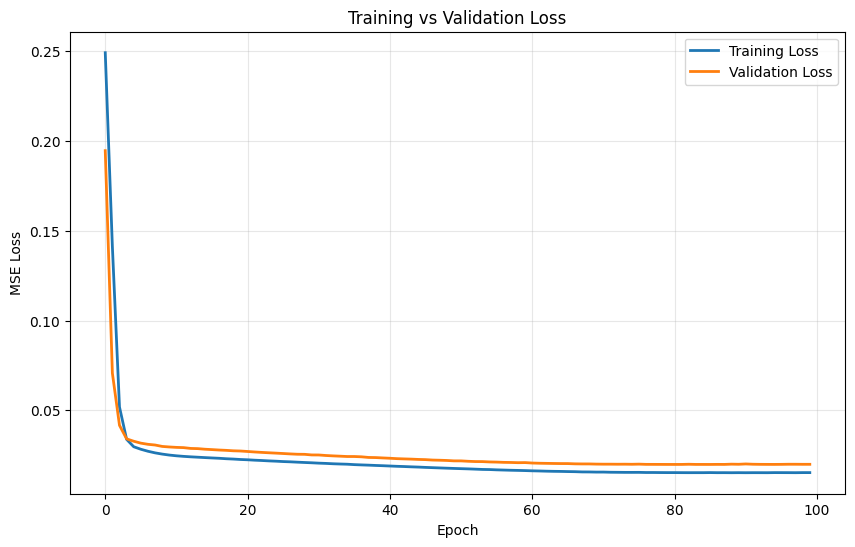

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
@torch.no_grad()
def predict_with_dates(loader, dates, scaler):
    model.eval()
    preds = []
    actuals = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)

        preds.append(output.cpu().numpy())
        actuals.append(y.cpu().numpy())

    preds = np.concatenate(preds).flatten().reshape(-1, 1)
    actuals = np.concatenate(actuals).flatten().reshape(-1, 1)

    # inverse transform
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)

    # include dates
    date_values = dates.iloc[-len(preds):].to_numpy()

    return preds_inv.flatten(), actuals_inv.flatten(), date_values

In [ ]:
test_preds_inv, test_actual_inv, test_dates = predict_with_dates(
    test_loader,
    test_df['date'],
    scaler_y
)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_actual_inv, test_preds_inv))
print(f"Test RMSE (original scale): {rmse:.4f} °F")

Test RMSE (original scale): 6.6419 °F


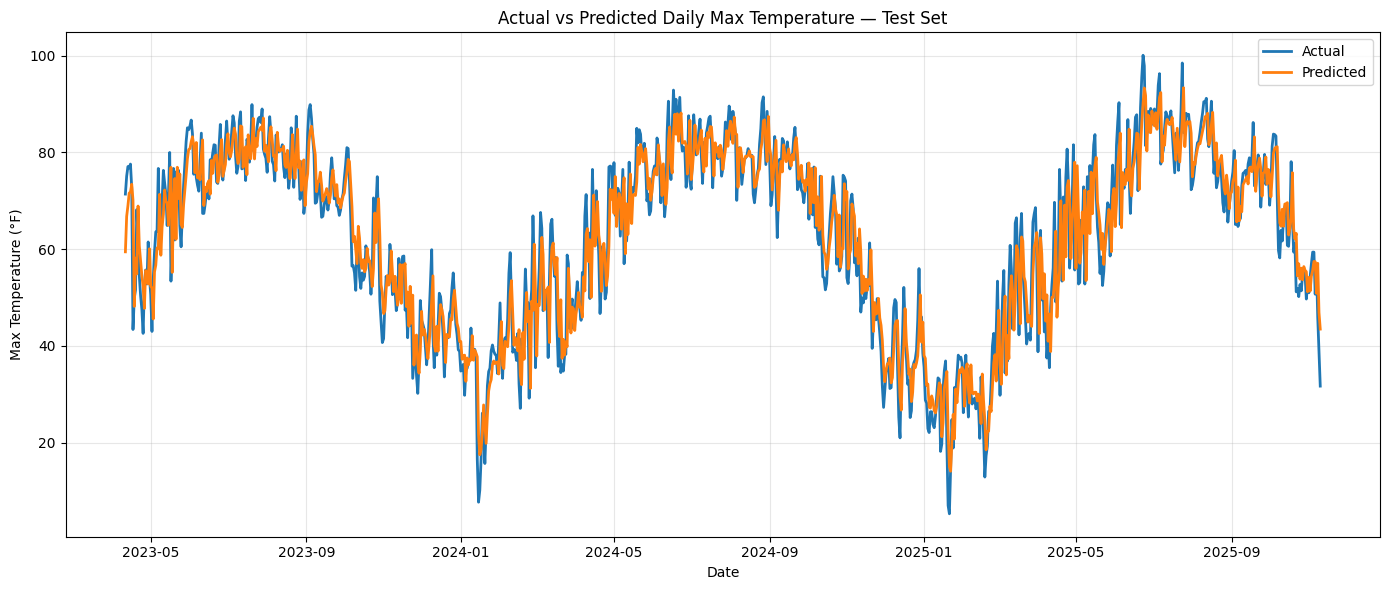

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test_dates, test_actual_inv, label="Actual", linewidth=2)
plt.plot(test_dates, test_preds_inv, label="Predicted", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Max Temperature (°F)")
plt.title("Actual vs Predicted Daily Max Temperature — Test Set")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
